In [1]:
import os
import pandas as pd
import collections
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import re
import numpy as np
import spacy
import textdescriptives as td
from tqdm import tqdm

In [2]:
def load_data(path_to_folder):
    all_files = os.listdir(path_to_folder) # get all files
    valid_files = [file for file in all_files if 'errors' not in file] # remove error logs
    dfs = [] # empty list
    for file in valid_files:
        file_path = os.path.join(path_to_folder, file)
        filename = str(file.split('.')[0])
        fandom = str(filename.split('_')[0])
        au = str(filename.split('_')[1])
        try:
            print(f"Loading file: {file}")
            df = pd.read_csv(file_path)
            df['Main fandom'] = fandom
            df['Main AU'] = au
            dfs.append(df) # load files into list of dfs
            print(f"Finished loading file: {file}")
        except Exception as e:
            print(f"Could not read {file}: {e}") # in case sth is missed
    big_df = pd.concat(dfs, ignore_index=True) # pull into df
    return big_df

path = os.path.join('..', '..', 'texts')
df = load_data(path)

Loading file: hp_coffeeshop.csv
Finished loading file: hp_coffeeshop.csv
Loading file: hp_vampire.csv
Finished loading file: hp_vampire.csv
Loading file: mcu_vampire.csv
Finished loading file: mcu_vampire.csv
Loading file: bts_vampire.csv
Finished loading file: bts_vampire.csv
Loading file: bnha_royalty.csv
Finished loading file: bnha_royalty.csv
Loading file: mcu_royalty.csv
Finished loading file: mcu_royalty.csv
Loading file: mcu_coffeeshop.csv
Finished loading file: mcu_coffeeshop.csv
Loading file: bnha_coffeeshop.csv
Finished loading file: bnha_coffeeshop.csv
Loading file: bts_coffeeshop.csv
Finished loading file: bts_coffeeshop.csv
Loading file: bnha_vampire.csv
Finished loading file: bnha_vampire.csv
Loading file: mcu_soulmates.csv
Finished loading file: mcu_soulmates.csv
Loading file: bts_soulmates.csv
Finished loading file: bts_soulmates.csv
Loading file: hp_royalty.csv
Finished loading file: hp_royalty.csv
Loading file: hp_soulmates.csv
Finished loading file: hp_soulmates.csv


In [3]:
def str_to_list(value):
    if pd.isna(value): 
        value = []
        return value
    elif isinstance(value, str):
        value = value.strip("[]").replace("'", "").split(", ")
        return value
    else:
        pass
    
def str_cols_to_list(data, cols):
    for col in cols:
        data[col] = data[col].apply(str_to_list)
    return data

def str_to_int(value):
    if pd.isna(value): 
        value = 0
        value = int(value)
        return value
    elif isinstance(value, int):
        pass
    elif isinstance(value, float):
        value = int(value)
        return(value)
    elif isinstance(value, str):
        value = value.replace(",", "").replace(".0", "")
        value = int(value)
        return value
    else:
        print(f"Look at this weird value: {value}")

def str_cols_to_int(data, cols):
    for col in cols:
        data[col] = data[col].apply(str_to_int)
    return data

def str_to_date(data, cols):
    for col in cols:
        data[col] = pd.to_datetime(data[col], errors='coerce')
    return data

df[['current_chapters', 'total_chapters']] = df['chapters'].str.split('/', expand=True)
df = df.drop(columns=['chapters'])

str_columns = ['author', 'category', 'fandom', 'relationship', 'character', 'additional tags', 'all_kudos']
df = str_cols_to_list(df, str_columns)

int_columns = ['words', 'comments', 'kudos', 'bookmarks', 'hits']
df = str_cols_to_int(df, int_columns)

date_cols = ['published', 'status date']
df = str_to_date(df, date_cols)

In [4]:
df = df[df['words'] >= 600]

In [12]:
snippets = []

for text in tqdm(list(df["body"]), total=df.shape[0]):
    text = str(text)
    clean_text = text.replace("\n", " ")
    tokenized_text = clean_text.split(" ")
    tokenized_text = [token for token in tokenized_text if token != ""]

    snippets.append(" ".join(tokenized_text[100:600]))


100%|██████████| 26938/26938 [00:26<00:00, 1015.21it/s]


In [20]:
df["snippet"] = snippets

In [13]:
spacy.load("en_core_web_lg")

In [14]:
metrics = td.extract_metrics(
    text=tqdm(snippets), 
    spacy_model='en_core_web_lg', 
    metrics=['quality'])
df['passed_qual_check'] = list(metrics['passed_quality_check'])

100%|██████████| 26938/26938 [51:28<00:00,  8.72it/s]  


In [17]:
pkl_path = os.path.join("..", "obj", "prepped.pkl")
df.to_pickle(pkl_path)

In [16]:
df['passed_qual_check'].value_counts()

passed_qual_check
True     26725
False      213
Name: count, dtype: int64

In [20]:
cross_df = pd.read_csv(os.path.join('..', '..', 'cross.csv'), header=None)

In [22]:
cross_values = cross_df.iloc[:, 0].values

In [24]:
df = df[~df['work_id'].isin(cross_values)]

In [ ]:
# remove crossovers!
# remove fics that are too short
# tokenize & assess quality
# remove duplicates

In [26]:
df = df.drop_duplicates(subset='work_id')

In [28]:
df.shape

(25053, 26)

In [30]:
stats = df.groupby(['Main fandom', 'Main AU']).size().reset_index(name='count')

In [31]:
stats

,Main fandom,Main AU,count
0,bnha,coffeeshop,1185
1,bnha,royalty,1135
2,bnha,soulmates,2948
3,bnha,vampire,710
4,bts,coffeeshop,1547
5,bts,royalty,1923
6,bts,soulmates,3171
7,bts,vampire,1729
8,hp,coffeeshop,998
9,hp,royalty,682


In [10]:
def int_to_log(value):
    if value!=0:
        value = np.log(value)
    return value
def int_cols_to_log(data, cols):
    for col in cols:
        data[f'log_{col}'] = data[col].apply(int_to_log)
    return data

In [33]:
int_columns = ['words', 'comments', 'kudos', 'bookmarks', 'hits']
df = int_cols_to_log(df, int_columns)

In [13]:
df_filtered = df[df['fandom'].apply(lambda x: len(x) > 1)]

In [14]:
df_filtered

,work_id,title,author,rating,category,fandom,relationship,character,additional tags,language,...,kudos,bookmarks,hits,all_kudos,all_bookmarks,body,Main fandom,Main AU,current_chapters,total_chapters
2,62583508,Talkin' Tom Riddles,[Rosa_Quills (Rosa_Inglese)],Teen And Up Audiences,"[F/M, M/M, Multi]","[Pocket Monsters | Pokemon (Anime 1997-2023), ...","[Gou | Goh & Satoshi | Ash Ketchum, Gou | Goh/...","[Hanako | Delia Ketchum, Satoshi | Ash Ketchum]","[Crossover, Alternate Universe - Modern with M...",English,...,2,0,44,"[Laudasur, skylark_1234]",[],"\n\nTalkin' Tom Riddles\n\n\n\n \n\n""So, Mum. ...",hp,coffeeshop,1,1
3,34137433,some sunsick day - kitchenr011,[foresthoney],Explicit,[M/M],"[Harry Potter - J. K. Rowling, Marauders - Fan...",[Sirius Black/Remus Lupin],"[Sirius Black, James Potter, Lily Evans Potter...","[Alternate Universe, Alternate Universe - Coff...",English,...,292,183,27923,"[asherr8, lifeonmars11, fnwkqkscnfjdiwwkscmnvj...",[],this fic was originally written and posted by ...,hp,coffeeshop,3,?
9,62689270,Dough and Taxes,[Ilikerocks22],Mature,[F/M],"[Harry Potter - J. K. Rowling, Stranger Than F...","[Neville Longbottom/Pansy Parkinson, Minor or ...","[Neville Longbottom, Pansy Parkinson, Hermione...",[Dont look too hard at the plot youll hurt you...,English,...,13,0,67,"[snookolive, StoneAvalanche, HomeOfSapiens, Am...",[],\n\n\n\nNeville was an accountant.\n\nAs if th...,hp,coffeeshop,1,10
10,61154731,Now I'm Stuck By The Glue- Oh And You!,[decomposedmoonlight13],Not Rated,"[F/F, M/M, Other]","[Marauders - Fandom, Harry Potter - J. K. Rowl...","[Regulus Black & Pandora Lovegood, Regulus Bla...","[Pandora Lovegood, Regulus Black, Barty Crouch...","[Alternate Universe - Coffee Shops & Cafes, re...",English,...,29,6,537,"[rabisloml, genyascfin, Prydain, alicebear, th...",[],If you had told ten year old Pandora Rosier th...,hp,coffeeshop,6,10
32,54910090,"hello,darling.",[Writerxt0],Not Rated,[],"[Marauders - Fandom, Wolfstar - Fandom]","[Sirius Black/Remus Lupin, Regulus Black/James...","[Sirius Black, Remus Lupin, James Potter, Regu...","[coffee shop AU, Deaf Remus Lupin, Deaf Charac...",English,...,178,23,3833,"[Infantinement, ThrillOfTheChase, Star_shark, ...",[],Meeting The barista.\n\nanything said in sign ...,hp,coffeeshop,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28335,16364897,Night Of The Red Moons(BTS),[ARMY_FOREVER14],Mature,"[F/M, M/M]","[bangtansonyeondan | Bangtan Boys | BTS, GOT7]","[JungkookxReader, FutureShips]","[Jung Hoseok | J-Hope, Kim Namjoon | RM, Kim T...","[vampire, royaltyau, Death, Blood, Violence, A...",English,...,11,1,346,"[KnochuIbamM, Harumi_Misaki, Midania]",[],Y/N POV\n\n I've always wondered why there w...,bts,royalty,2,?
28360,11061648,I Would Give you the Moon (If Only I Could Reach),[forheart],Not Rated,[M/M],"[bangtansonyeondan | Bangtan Boys | BTS, TWICE...","[Kim Namjoon | Rap Monster/Park Jimin, Kim Seo...","[Park Jimin (BTS), Jung Hoseok | J-Hope, Kim N...","[Alpha/Beta/Omega Dynamics, Alternate Universe...",English,...,673,84,9396,"[squishy_who, Claudichi, morbid13th, Northern_...",[],\n (See the end of the chapter for n...,bts,royalty,3,3
28406,9960209,Personal Musings,[robotkeychain],Teen And Up Audiences,[M/M],"[EXO (Band), bangtansonyeondan | Bangtan Boys ...","[Kim Jongdae | Chen/Kim Joonmyun | Suho, Kim J...","[Kim Joonmyun | Suho, Kim Jongdae | Chen, Wu Y...","[florist!suchen, Blind Date, online friends!au...",English,...,44,5,749,"[bhimbra, liamisbae, sonika213, bobohupouts, H...",[],Jongdae has a problem. His problem is shorter ...,bts,royalty,24,?
28407,9945377,Miscellany,[jinwann],Teen And Up Audiences,[M/M],"[VIXX, bangtansonyeondan | Bangtan Boys | BTS]","[Kim Seokjin | Jin/Lee Jaehwan | Ken, Do Kyung...","[Lee Jaehwan | Ken, Kim Seokjin | Jin, Cha Hak...","[Fluff, Implied Sexual Content, probably, Alte...",English,...,83,3,1086,"[MiaBlack88, RainyJade, Reiiyo, Mina80, The_Wi...",[],"It had probably b

In [45]:
df.iloc[0:20, 11]

0       Updated
1       Updated
2     Completed
3       Updated
4       Updated
5       Updated
6     Completed
7       Updated
8       Updated
9       Updated
10      Updated
11      Updated
12      Updated
13      Updated
14      Updated
15      Updated
16    Completed
17      Updated
18      Updated
19      Updated
Name: status, dtype: object

<Axes: xlabel='year'>

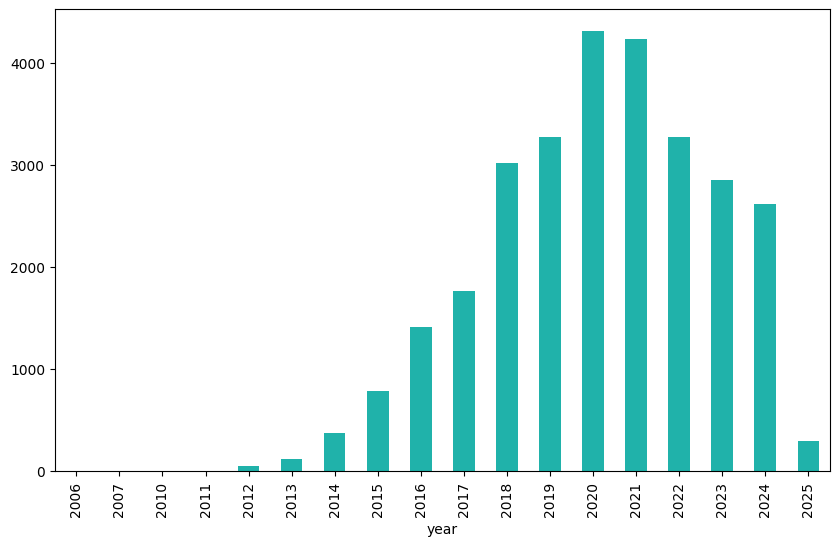

In [49]:
df['year'] = df['published'].dt.year

# Group by the 'year' column and count occurrences
year_counts = df['year'].value_counts().sort_index()

# Plot the count of rows for each year
plt.figure(figsize=(10, 6))
year_counts.plot(kind='bar', color='lightseagreen')

<Axes: ylabel='Frequency'>

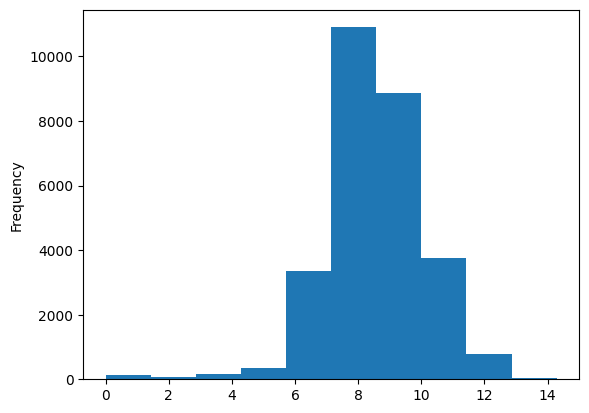

In [36]:
df['log_words'].plot(kind='hist')

In [8]:
meta = df.drop(columns='body')
txt = df[['work_id', 'body', 'Main fandom', 'Main AU']]